# YData Quality - Data Drift Tutorial
Time-to-Value: 10 minutes

This notebook provides a tutorial for the ydata_quality package funcionality for drift analysis.

**Structure:**

0. A data drifting introduction
1. Load dataset
2. Train and wrap example model
3. Distort dataset
4. Instantiate the Data Quality engine
5. Run the quality checks
6. Assess the warnings
7. (Extra) Detailed overview

## A data drifting introduction
### What is data drift?
Data drift is a broad term used for differences in the data observed by a model during training and prediction time.

These divergences are part of most real world settings and can hinder the task of learning a mapping from input (features) space to output space (labels).
Sometimes these divergences are intended, such as in __[Domain Adaptation](https://en.wikipedia.org/wiki/Domain_adaptation)__ applications where the success is defined by the model's ability to learn from a rich, source dataset and generalize this capacity to a target dataset where labelled data can be scarce or unavailable.
On other cases, the differences are unintended and reflect the dynamic nature of the underlying use case (e.g. stock prices) or are just a reflex of the difficulty of creating a representative dataset of the target population.

For the three scenarios presented above, drift is an important concept and a pivotal aspect of Data Quality.
***
### Types of data drift
We identify and diagnose the three main types of data drift:
*  **Covariate, input drift (X)**
    *  Drift detected in the independent features between a reference sample (e.g. train data) and a target sample (p.e. test data). In an ideal scenario we expect $X_{ref}$ = $X_{target}$, which means that, statistically, input data from the target appears to be generated from the same distribution as the reference data.
*  **Label drift (Y)**
    *  Drift detected in the dependent feature between a reference sample and a target sample. In an ideal scenario we expect $Y_{ref}$ = $Y_{target}$, which means that, statistically, labels from the reference sample appear to be generated from the same distribution.
*  **Concept drift (Y|X)**
    *  Drift detected in the input/output mappings defined by a model between a reference and a target sample. This gains more relevance if we can first establish that there is no covariate or label drift. In an ideal scenario we expect $Y_{ref}|X_{ref}$ = $Y_{target}|X_{target}$, which means that, statistically, the model appears to follow the same mapping process in predicting the labels from the reference samples.
***
### How do we detect data drift
There are many strategies to detect data drift. Some strategies rely on fitting a classifier to distinguish which observations come from a reference sample and define the existence of drift based on the performance of this classifier (a bad performance suggests a low data drift). Other strategies rely on empirical distance metrics like the two sample __[Maximum Mean Discrepancy](https://jmlr.csail.mit.edu/papers/volume13/gretton12a/gretton12a.pdf)__ or on classical statistical tests and hypothesis testing.

To depend on the least assumptions, we choose the latter alternative. For all numerical features we apply a __[Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)__ and for categorical data we use the __[Chi-Squared test](https://en.wikipedia.org/wiki/Chi-squared_test)__. The  standard p-value thresholds are used to determine the outcome of the performed tests. For concept drift we abstain from trying to fit a model and evaluating drift with that model, because that is no guarantee of similar behaviour by a user's model. For this reason we accomodate user provided models and analyse the model behaviour for the intended task which should provide the most useful insights.

Since input data (X) is often multi-dimensional, we agglomerate the results of multiple statistical tests by applying a __[Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction)__ to the p-value. This allows for a global assessment of drift from many individual statistical tests. So, when we say that there is covariate drift, we mean that at least one of the features has failed a statistical test with higher likelihood than our Bonferroni corrected threshold.


# Drift engine demo and tutorial
## Imports

In [1]:
import random
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from ydata_quality.drift import DriftAnalyser, ModelWrapper

## Load the example dataset
We will use a faulty version of the wine dataset available from the sklearn package.

In [2]:
df = pd.read_csv('../datasets/original/wine.csv')
sample = pd.read_csv('../datasets/transformed/wine_sample.csv')

## Train and wrap example model
We will train a simple classifier on the full dataset and wrap it with the ModelWrapper class just to demonstrate the engine's concept drift test.

In [3]:
# First we train a classifier
x = df.loc[:, df.columns != 'target']
y = df['target']
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x, y)

# Now we wrap it by directly instantiating the ModelWrapper class.
# The wrapper will handle using __call__ or predict method depending on the passed model
wrapped_model = ModelWrapper(clf)

## Create the engine
Each engine contains the checks and tests for each suite. To create a DriftAnalyser, you provide:
- ref: reference DataFrame, DataFrame that we will assume as the reference for the modelled population
- sample (optional): A test sample which we will compare against the reference. It should have the same schema as the reference dataframe, although the label column can always be optional for this sample (even when provided for the reference)
- label (optional): A string defining the label feature (will be searched for both in the reference and test samples)
- model (optional): A callable that inherits or directly instantiates ModelWrapper. This is supposed to wrap a label prediction model that consumes the provided sample covariates as input
- holdout (optional): A float defining the fraction of rows from the reference sample that are held-out for the reference tests. A 20% random subsample is taken by default.
- random_state (optional): Integer used as the Random Number Generator seed, used to guarantee reproducibility of random sample splits. Pass None for no reproducibility. 

In [4]:
da = DriftAnalyser(ref=df, sample=sample, label='target', model=wrapped_model, random_state=42)

### Full Evaluation
The easiest way to assess the data quality analysis is to run `.evaluate()` which returns a list of warnings for each quality check. 

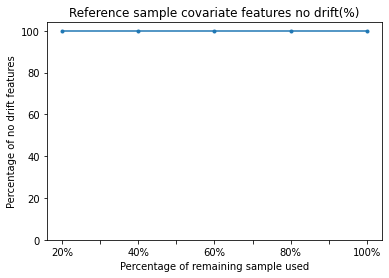

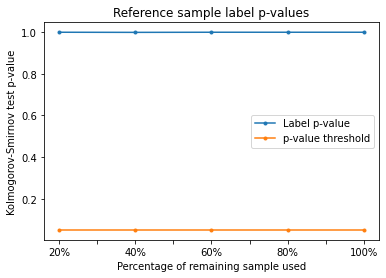

[CONCEPT DRIFT] Concept drift was not detected between the reference and the test samples.


In [5]:
results = da.evaluate()

## Check the status
After running the data quality checks, you can check the warnings for each individual test. The warnings are suited by priority and have additional details that can provide better insights for Data Scientists.

In [6]:
da.report()

Warnings count by priority:
	Priority 2: 2 warning(s)
	TOTAL: 2 warning(s)
List of warnings sorted by priority:
	[SAMPLE LABEL DRIFT] The label accused drift in the sample test with a p-test of 0.0001, which is under the threshold 0.05. The label of the test sample does not appear to be representative of the reference sample. (Priority 2: usage allowed, limited human intelligibility)
	[SAMPLE COVARIATE DRIFT] 1 features accused drift in the sample test. The covariates of the test sample do not appear to be representative of the reference sample. (Priority 2: usage allowed, limited human intelligibility)


### Quality Warning

In [7]:
# Get a sample warning
sample_warning = da.get_warnings()[0]

In [8]:
# Check the details
sample_warning.test, sample_warning.description, sample_warning.priority

('Sample label drift',
 'The label accused drift in the sample test with a p-test of 0.0001, which is under the threshold 0.05. The label of the test sample does not appear to be representative of the reference sample.',
 <Priority.P2: 2>)

In [9]:
# Retrieve the relevant data from the warning
sample_warning_data = sample_warning.data

## Full Test Suite
In this section, you will find a detailed overview of the available tests in the Data Drift module of ydata_quality.

### Reference sample covariate drift

In this test we look for evidence of the reference sample covariates being representative of the underlying population.
A holdout is taken (20% by default), and increasing size random slices of data are taken from the remaining 80% data.
The remaining data slices are tested against the holdout in attempt to provide drift evidence.

Due to the complexity of this strategy, we provide the tooling for Data Scientists to infer the healthiness of the reference sample and avoid drawing conclusions automatically based on heuristics. An healthy indicator of data quality would be a monotonic increase of the percentage of features with no drift evidence and increasing individual p-values for the least performant tests, as the remaining data slices are increased.

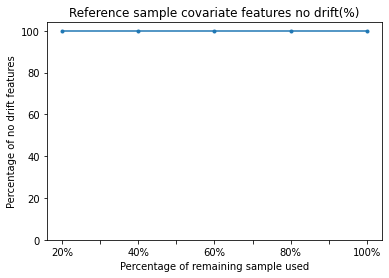

In [10]:
ref_cov_drift_out = da.ref_covariate_drift()

### Reference sample label drift

In this test we look for evidence of the reference sample labels being representative of the underlying population.
The same holdout and undersampling strategy from the previous test are used and, since now we have a univariate test, only the p-values for the increasing remaining data slices are shown.

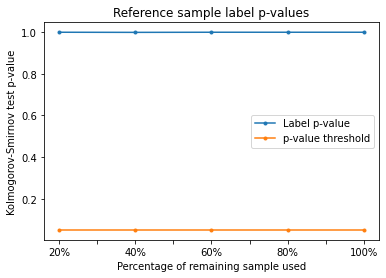

In [11]:
# Here we notice the effects of changing all labels in the test sample to a fixed class
ref_label_drift_out = da.ref_label_drift()

### Test sample covariate drift

In this test we look for evidence of the test sample covariates drifting from the reference sample.
The full reference sample is used in modelling the distribution against which we evaluate the test sample.

In the multivariate case, Bonferroni correction for the p-value is used in order to mitigate eventual false positives in the drift diagnosis.
If any feature from the covariates accuses drift, we raise a warning for the full sample.
In the case that no drift was detected, but there were failing tests due to other data issues (e.g. different support on categoricals), we will raise your attention with a lower priority warning and with recommendations (usually this is due to too small test samples).

In [12]:
# As expected the corrupted alcohol feature is detected after the corruption step, a small boost of 0.8 vol(%) triggered this alarm
sample_cov_drift_out = da.sample_covariate_drift()
sample_cov_drift_out.head()

,Statistic,Statistic Value,p-value,Verdict
alcohol,Kolmogorov-Smirnov,0.371723,0.00033,Drift
malic_acid,Kolmogorov-Smirnov,0.081149,0.977921,OK
ash,Kolmogorov-Smirnov,0.068664,0.99666,OK
alcalinity_of_ash,Kolmogorov-Smirnov,0.092072,0.93743,OK
magnesium,Kolmogorov-Smirnov,0.082397,0.974267,OK


### Test sample label drift

In this test we look for evidence of the test sample label drifting from the reference sample.
The same strategy from the previous step applies.
If the label accuses drift, we raise a warning for the test sample.
In the case that no drift was detected, but there was a failing test due to other data issues (e.g. different support on categoricals), we will raise your attention with a lower priority warning and a recommendation (usually this is due to too small test samples).

In [13]:
sample_label_drift_out = da.sample_label_drift()
sample_label_drift_out

Statistic          Kolmogorov-Smirnov
Statistic Value              0.390762
p-value                      0.000127
Verdict                         Drift
dtype: object

### Test concept drift

In this test we look for evidence of concept drift.
If the provided model produces output for the test sample which appears not to be representative of the output generated from the reference sample, concept drift is detected.

In [14]:
sample_concept_drift_out = da.sample_concept_drift()
sample_concept_drift_out

[CONCEPT DRIFT] Concept drift was not detected between the reference and the test samples.


Statistic          Kolmogorov-Smirnov
Statistic Value               0.06367
p-value                       0.99884
Verdict                            OK
dtype: object